<img style="float: right;" src="icon.jpg">

# Eye of Another World :: Weapon Visualizer


by  <a href="mailto:X00193937@mytudublin.ie">Jorge Jimenez Garcia</a> 


## Sections:
* <a href="#dep_and_prereq"> Dependencies, Imports, Prerequisites and Global Configs </a>
* <a href="#prelude">Prelude </a>
* <a href="#visualization"> Visualization </a>
    * <a href="#usage stats"> Usage Statistics </a>
    * <a href="#density"> Density plots </a>

<a name="dep_and_prereq"> </a>
### Dependencies, Imports, Prerequisites and Global Configs

In [199]:

# IMPORTS-------------------------
import sqlite3
from collections import Counter
import ctypes
from sys import argv
import pickle
import json
import zipfile
import requests
import os
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# CONSTANTS-----------------------------
BNET_URL = 'http://Bungie.net'
MANIFEST_SUFFIX = '/Platform/Destiny2/Manifest/'
WEAPON_SLOT_NAMES = ['', 'Primary', 'Special', 'Power']

PROPERTIES_QUERY = """
SELECT json_extract(json, '$.displayProperties.name'), json_extract(json, '$.inventory.tierTypeName'), json_extract(json, '$.itemTypeDisplayName'), json_extract(json, '$.equippingBlock.ammoType'), json_extract(json, '$.sockets.socketEntries'), json_extract(json, '$.stats.stats')
FROM DestinyInventoryItemDefinition WHERE id == {}
"""
FRAME_NAME_QUERY = """
SELECT json_extract(json, '$.displayProperties.name')
FROM DestinyInventoryItemDefinition WHERE id == {}
"""

HASH_STABILITY = str(155624089)
HASH_HANDLING = str(943549884)
HASH_RANGE = str(1240592695)
HASH_AIMASSIST = str(1345609583)
HASH_AIRBORNEEFF = str(2714457168)
HASH_RECOILDIR = str(2715839340)
HASH_ZOOM = str(3555269338)
HASH_MAGSIZE = str(3871231066)
HASH_IMPACT = str(4043523819)
HASH_RELOAD = str(4188031367)
HASH_RPM = str(4284893193)

##----SPECIFIC STATS TO CLASS--------

##???? these have chargetime? id == to fusion chargetime
HASH_BOW_DRAWTIME = str(447667954)
HASH_BOW_ACCURACY = str(1591432999)

HASH_FR_CHARGETIME = str(2961396640)

HASH_RLGL_VELOCITY = str(2523465841)
HASH_RLGL_BLASTRADIUS = str(3614673599)

HASH_GLAIVE_SHIELDDUR = str(1842278586)

HASH_SWORD_GUARDRES = str(209426660)
HASH_SWORD_GUARDEFF = str(2762071195)
HASH_SWORD_SWINGSPEED = str(2837207746) # ~rpm?
HASH_SWORD_CHARGERATE = str(3022301683)


_Config settings:_

#### Why leave out Exotic weapons?

Exotic weapons are the stand out in a players arsenal. Unique in their behaviour, they would be useless data in our study, since they have traits generally exclusive to them, and so including them in our pool of analyzed traits does not help us predict the popularity of gear, because no other item will have those traits

In [200]:
# CONFIG----------------------------
CONFIG__DF_IGNORE_EXOTICS = True
CONFIG__DATA_FILE_NAME = 'RAD1MODE84-from2022-09-23-to2022-09-26.d2data'

<a name="prelude" > </a>
### Prelude

Update the Manifest, open and ready the ocurrence data

#### Load the data file

In [201]:

# Read data file
with open(CONFIG__DATA_FILE_NAME, 'rb') as f:
    (weaponFreq, playerCount, gameSet) = pickle.load(f)

# Check Manifest, and update if needed
manifest_location = requests.get(BNET_URL + MANIFEST_SUFFIX).json()['Response']['mobileWorldContentPaths']['en']
DB_NAME = manifest_location[35:]
if not os.path.exists(DB_NAME):
    print('{} not found: Downloading Destiny Manifest, this may take a while...'.format(DB_NAME))
    manifest_zip = requests.get(BNET_URL + manifest_location).content
    print('Up-to-date Manifest downloaded:')
    with zipfile.ZipFile(BytesIO(manifest_zip)) as z:
        with open(DB_NAME, 'wb') as f:
            f.write(z.read(DB_NAME))


db = sqlite3.connect(DB_NAME).cursor()

name_l = []
weapon_type = []
weapon_archetype = []
weapon_slot = []
usage_absolute = []
usage_rate = []

# Stats
# TODO: What about weapons with different stat categories? (eg. Bows, Glaives, Sword, Rockets/GLs, Fusions)
stability = []
handling = []
rang = []
aim_assist = []
airborne_effectiveness = []
recoil_direction = []
zoom = []
magsize = []
impact = []
reload = []
rpm = []

bow_drawtime = []
bow_accuracy = []
fr_chargetime = []
rlgl_velocity = []
rlgl_blastradius = []
glaive_shieldduration = []
sword_guardresistence = []
sword_guardefficiency = []
sword_swingspeed = []
sword_chargerate = []


stat_arr = [stability,handling,rang,aim_assist,airborne_effectiveness,recoil_direction,zoom,magsize,impact,reload,rpm,bow_drawtime,bow_accuracy,fr_chargetime,rlgl_velocity,rlgl_blastradius,glaive_shieldduration,sword_guardresistence,sword_guardefficiency,sword_swingspeed,sword_chargerate]
stat_hash_arr = [HASH_STABILITY,HASH_HANDLING,HASH_RANGE,HASH_AIMASSIST,HASH_AIRBORNEEFF,HASH_RECOILDIR,HASH_ZOOM,HASH_MAGSIZE,HASH_IMPACT,HASH_RELOAD,HASH_RPM,HASH_BOW_DRAWTIME,HASH_BOW_ACCURACY,HASH_FR_CHARGETIME,HASH_RLGL_VELOCITY,HASH_RLGL_BLASTRADIUS,HASH_GLAIVE_SHIELDDUR,HASH_SWORD_GUARDRES,HASH_SWORD_GUARDEFF,HASH_SWORD_SWINGSPEED,HASH_SWORD_CHARGERATE]


slot_totals = {'Primary': 0, 'Special': 0, 'Power': 0 }
for weaponId, ct in weaponFreq.items():
        name, tier, weaponType, weaponSlot, sockets, stats = db.execute(PROPERTIES_QUERY.format(ctypes.c_int32(weaponId).value)).fetchall()[0]

        weaponSlot = WEAPON_SLOT_NAMES[weaponSlot]
        sockets = json.loads(sockets)
        stats = json.loads(stats)
        
        if tier != 'Exotic':
            frameId = sockets[0]['singleInitialItemHash']
            frame = db.execute(FRAME_NAME_QUERY.format(ctypes.c_int32(frameId).value)).fetchall()[0][0]
        else:
            if CONFIG__DF_IGNORE_EXOTICS:
                continue
            frame = 'Exotic'
            
        for idx, stat_hash in enumerate(stat_hash_arr):
            try:
                stat_arr[idx].append(stats[stat_hash]['value'])
            except KeyError:
                stat_arr[idx].append(None) # TODO: 0 or None?
        
        # Update lists for df
        name_l.append(name)
        weapon_type.append(weaponType)
        weapon_archetype.append(frame)
        weapon_slot.append(weaponSlot)
        slot_totals[weaponSlot] += ct
        usage_absolute.append(ct)


for i in range(len(weapon_slot)):
    slot = weapon_slot[i]
    uabs = usage_absolute[i]
    urat = uabs / slot_totals[slot]
    
    usage_rate.append( urat )
        

df = pd.DataFrame(
    {
        'Name': pd.Series(name_l, dtype='category'),
        'Weapon Type': pd.Series(weapon_type, dtype='category'),
        'Archetype': pd.Series(weapon_archetype, dtype='category'),
        'Slot': pd.Series(weapon_slot, dtype='category'),
        'Stability': stability,
        'Handling': handling,
        'Range': rang,
        'Aim Assistance': aim_assist,
        'Airborne Effectiveness': airborne_effectiveness,
        'Recoil Direction': recoil_direction,
        'Zoom': zoom,
        'Magazine Size': magsize,
        'Impact': impact,
        'Reload Speed': reload,
        'Rounds Per Minute': rpm,
        'Draw Time': bow_drawtime,
        'Accuracy': bow_accuracy,
        'Charge Time': fr_chargetime,
        'Velocity': rlgl_velocity,
        'Blast Radius': rlgl_blastradius,
        'Shield Duration': glaive_shieldduration,
        'Guard Resistance': sword_guardresistence,
        'Guard Efficiency': sword_guardefficiency,
        'Swing Speed': sword_swingspeed,
        'Charge Rate': sword_chargerate,
        'Usage Rate in Slot': usage_rate
        
    }
)
df

,Name,Weapon Type,Archetype,Slot,Stability,Handling,Range,Aim Assistance,Airborne Effectiveness,Recoil Direction,...,Accuracy,Charge Time,Velocity,Blast Radius,Shield Duration,Guard Resistance,Guard Efficiency,Swing Speed,Charge Rate,Usage Rate in Slot
0,Multimach CCX,Submachine Gun,Lightweight Frame,Primary,38.0,70.0,29.0,55.0,12.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.068182
1,The Palindrome (Adept),Hand Cannon,Adaptive Frame,Primary,58.0,50.0,50.0,79.0,21.0,98.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090909
2,Beloved,Sniper Rifle,Adaptive Frame,Special,46.0,47.0,50.0,68.0,3.0,77.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.173913
3,Cantata-57,Hand Cannon,Adaptive Frame,Primary,51.0,52.0,46.0,82.0,12.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022727
4,Wastelander M5,Shotgun,Lightweight Frame,Special,40.0,66.0,44.0,49.0,2.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.130435
5,The Inquisitor,Shotgun,Pinpoint Slug Frame,Special,50.0,76.0,73.0,35.0,5.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043478
6,Eye of Sol,Sniper Rifle,Adaptive Frame,Special,49.0,46.0,50.0,68.0,5.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065217
7,Forgiveness (Adept),Sidearm,Aggressive Burst,Primary,41.0,39.0,60.0,90.0,25.0,96.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022727
8,Found Verdict (Timelost),Shotgun,Aggressive Frame,Special,22.0,39.0,31.0,37.0,2.0,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065217
9,Austringer,Hand Cannon,Adaptive Frame,Primary,59.0,47.0,46.0,75.0,13.0,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.136364


<a name="visualization"> </a>
### Visualization

<a name="usage stats"> </a>
#### Usage statistics:

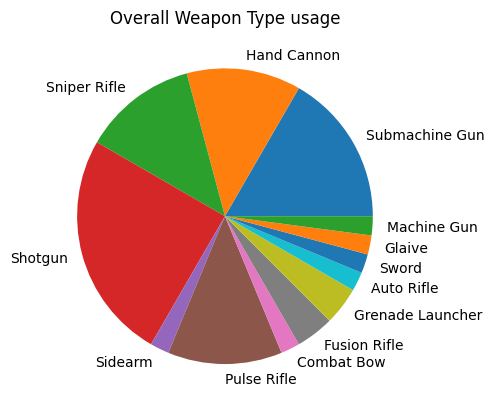

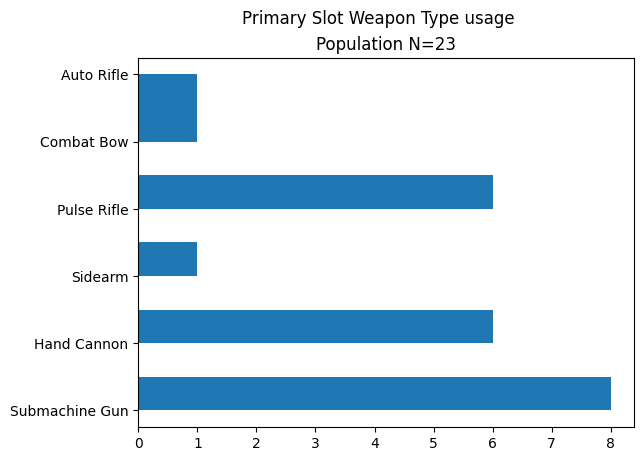

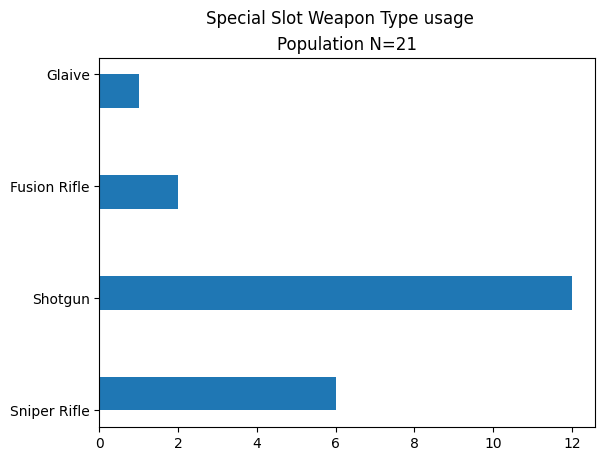

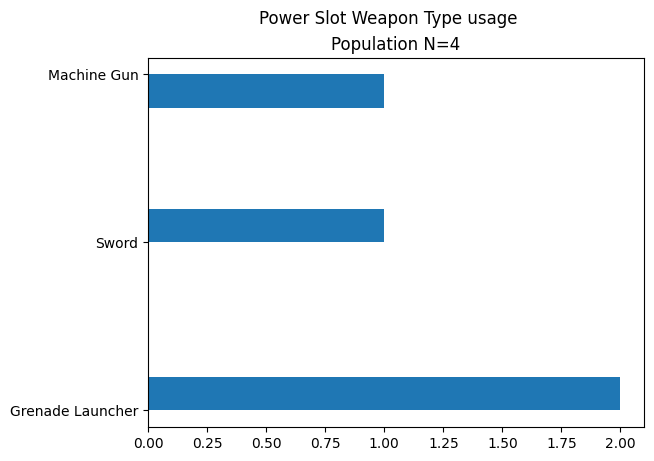

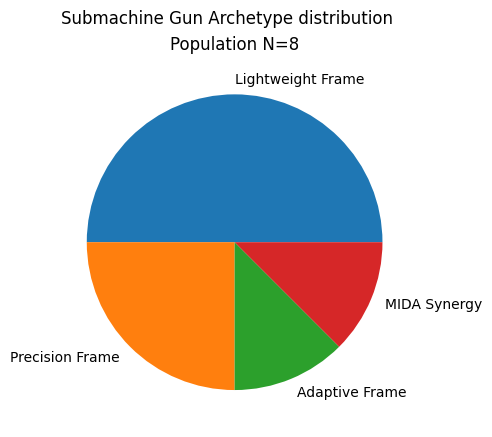

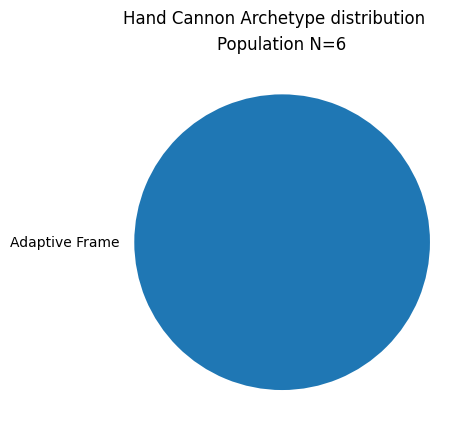

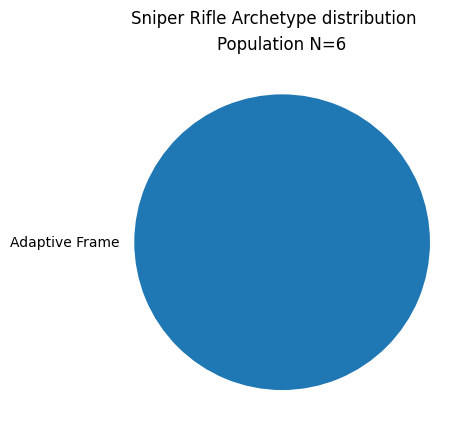

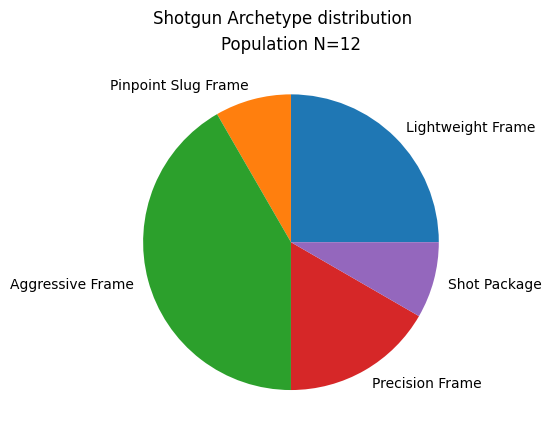

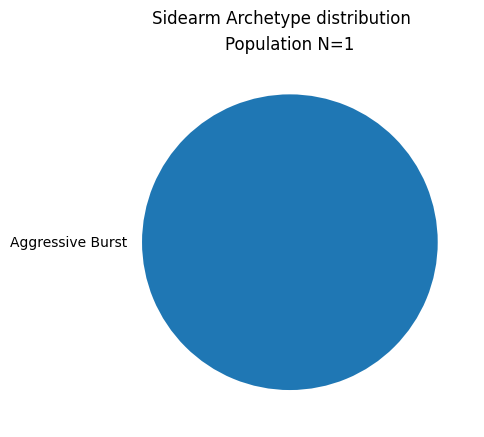

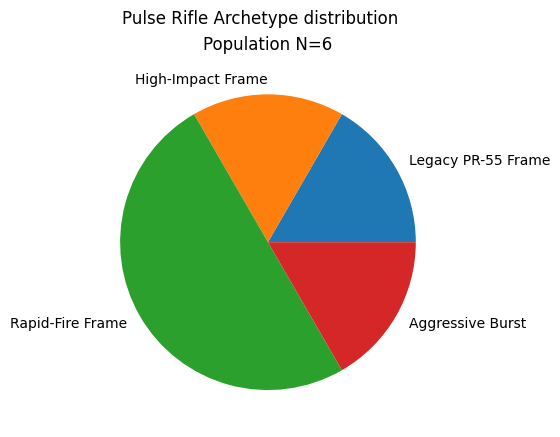

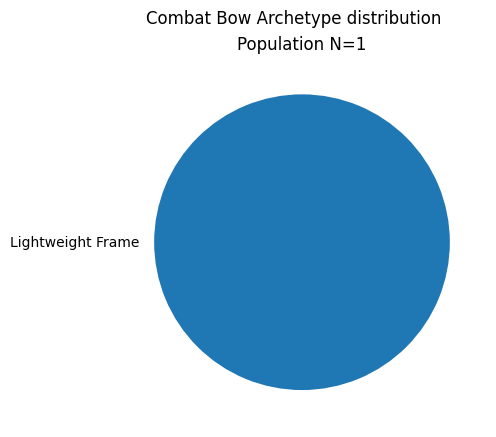

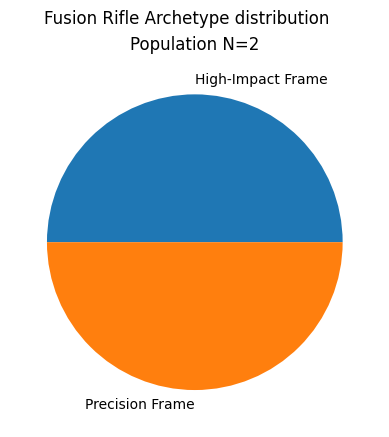

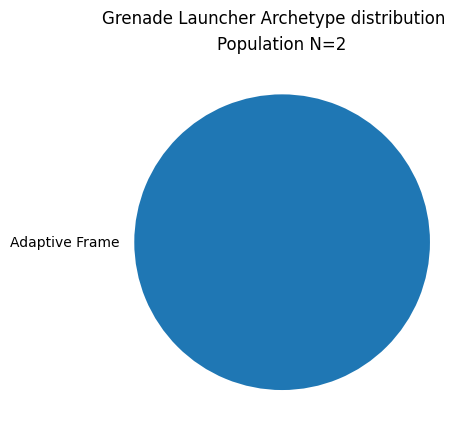

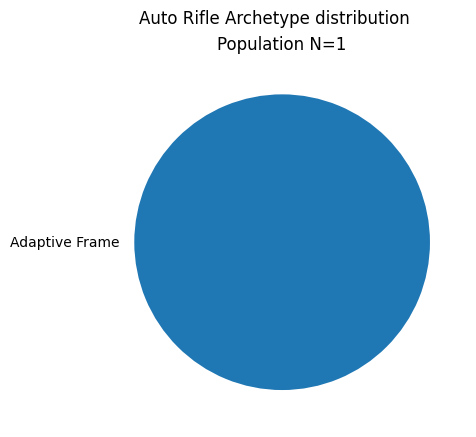

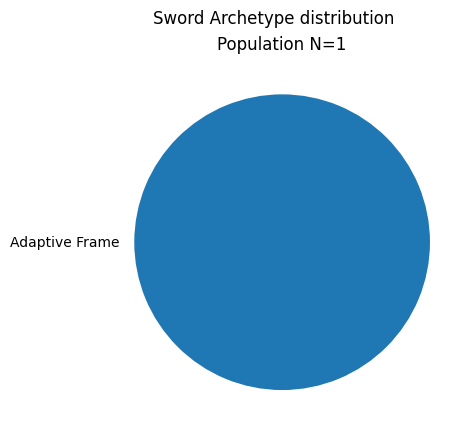

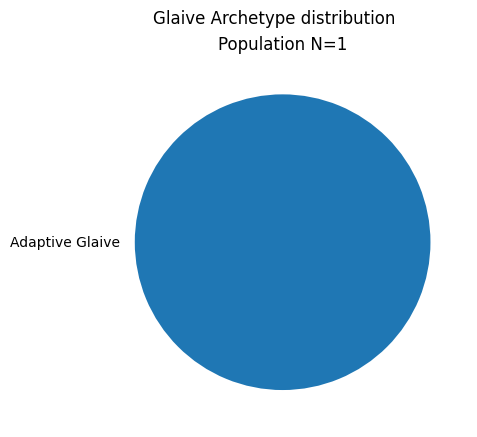

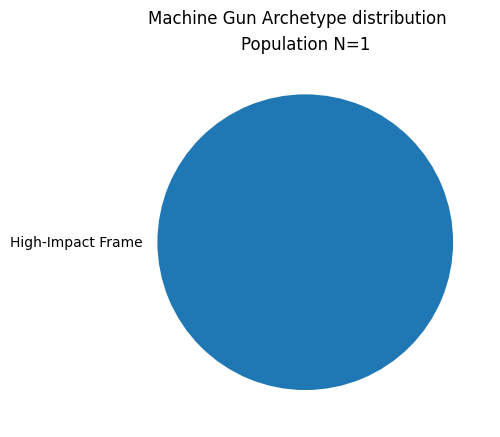

In [202]:

plt.title('Overall Weapon Type usage')
weapon_type_counter = Counter(df['Weapon Type'])
plt.pie(weapon_type_counter.values(), labels=weapon_type_counter.keys())
plt.show()


for slot in df['Slot'].unique():
    subset_by_slot = df.loc[df['Slot'] == slot]
    plt.suptitle('{} Slot Weapon Type usage'.format(slot))
    plt.title('Population N={}'.format(len(subset_by_slot)))
    plt.hist(subset_by_slot['Weapon Type'], orientation = 'horizontal')
    plt.show()

for weaponType in df['Weapon Type'].unique():
    subset_by_slot = df.loc[df['Weapon Type'] == weaponType]
    weapon_arch_counter = Counter(subset_by_slot['Archetype'])
    plt.suptitle('{} Archetype distribution'.format(weaponType))
    plt.title('Population N={}'.format(len(subset_by_slot)))
    plt.pie(weapon_arch_counter.values(), labels=weapon_arch_counter.keys())
    plt.show()
    


#### Stat distributions 

In [203]:
print('Stat Means:----------------------------\n')
print(df.mean(numeric_only=True))
print('\nStat Skews:--------------------------\n')
print(df.skew(numeric_only=True))
print('\nStat Standard Deviation--------------\n')
print(df.std(numeric_only=True))

Stat Means:----------------------------

Stability                  43.106383
Handling                   46.191489
Range                      46.400000
Aim Assistance             60.404255
Airborne Effectiveness     11.021277
Recoil Direction           74.652174
Zoom                       17.808511
Magazine Size              17.510638
Impact                     57.695652
Reload Speed               39.446809
Rounds Per Minute         299.659091
Draw Time                 580.000000
Accuracy                   24.000000
Charge Time               376.200000
Velocity                   31.500000
Blast Radius               50.000000
Shield Duration            42.000000
Guard Resistance            0.000000
Guard Efficiency            0.000000
Swing Speed                40.000000
Charge Rate                20.000000
Usage Rate in Slot          0.062500
dtype: float64

Stat Skews:--------------------------

Stability                -1.254527
Handling                  0.219341
Range               

<a name="density"> </a>
#### Density plots

ValueError: `dataset` input should have multiple elements.

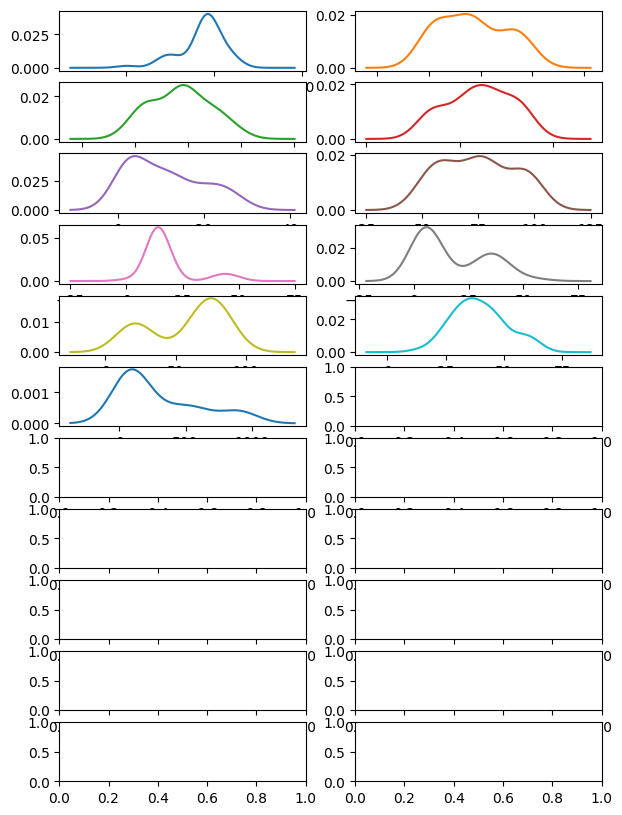

In [204]:
plt.rc('font', size=10)
df.plot(kind='density', subplots=True, layout=(11,2), figsize=(7,10), sharex=False)
plt.show()

In [ ]:
pd.plotting.scatter_matrix(df, figsize=(40, 40))
plt.show()